#### Model Evaluation and Model Evaluation Metrics

#### <font color = 'blue'> Model Evaluation </font>
- Train Score vs Test Score Plot
- Bias Variance Plot

In [1]:
import pandas as pd
import numpy as np

# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
df = pd.read_csv(url, names=names)
df.to_csv("diabetes data")

In [2]:
from sklearn import model_selection

def grid_search_best_model(estimator, grid, X, y, cv=10, scoring='accuracy'):
    grid_estimator = model_selection.GridSearchCV(estimator, grid, scoring=scoring, cv=cv, iid = True, return_train_score=True)
    grid_estimator.fit(X, y)
    best_est = grid_estimator.best_estimator_
    cv_results = grid_estimator.cv_results_
    print("Best parameters:" + str(grid_estimator.best_params_) )
    print("Validation score:" + str(grid_estimator.best_score_) )
    print("Train score:" + str(grid_estimator.score(X, y)) )

    return best_est, cv_results

In [3]:
from sklearn.model_selection import train_test_split

independent_features = df.drop(['class'], axis = 1).columns
target_feature = ['class']

X_train, X_test, y_train, y_test = train_test_split(df[independent_features], df[target_feature], test_size=0.3, random_state=0)

In [4]:
# Using Random Forest for Classification

from sklearn import ensemble

rf_estimator = ensemble.RandomForestClassifier()
rf_grid  = {'max_depth':list(range(1,9)), 'n_estimators':[100, 500, 1000] }
rf_final_estimator , rf_cv_results= grid_search_best_model(rf_estimator, rf_grid, X_train, y_train.values.ravel())
rf = rf_final_estimator.fit(X_train, y_train.values.ravel())

y_pred = rf.predict(X_train)

Best parameters:{'max_depth': 4, 'n_estimators': 500}
Validation score:0.7635009310986964
Train score:0.8286778398510242


##### <font color = 'blue'> Train Score vs Test Score Plot </font>

In [15]:
keys = ['params', 'mean_validation_score', 'mean_train_score']
cv_metrics = pd.DataFrame(columns = keys)
cv_metrics['params'] = rf_cv_results['params']
cv_metrics['params'] = cv_metrics['params'].apply(str)
cv_metrics['mean_validation_score'] = rf_cv_results['mean_test_score']
cv_metrics['mean_train_score'] = rf_cv_results['mean_train_score']
cv_metrics['train_validation_diff'] = cv_metrics['mean_train_score'] - cv_metrics['mean_validation_score']

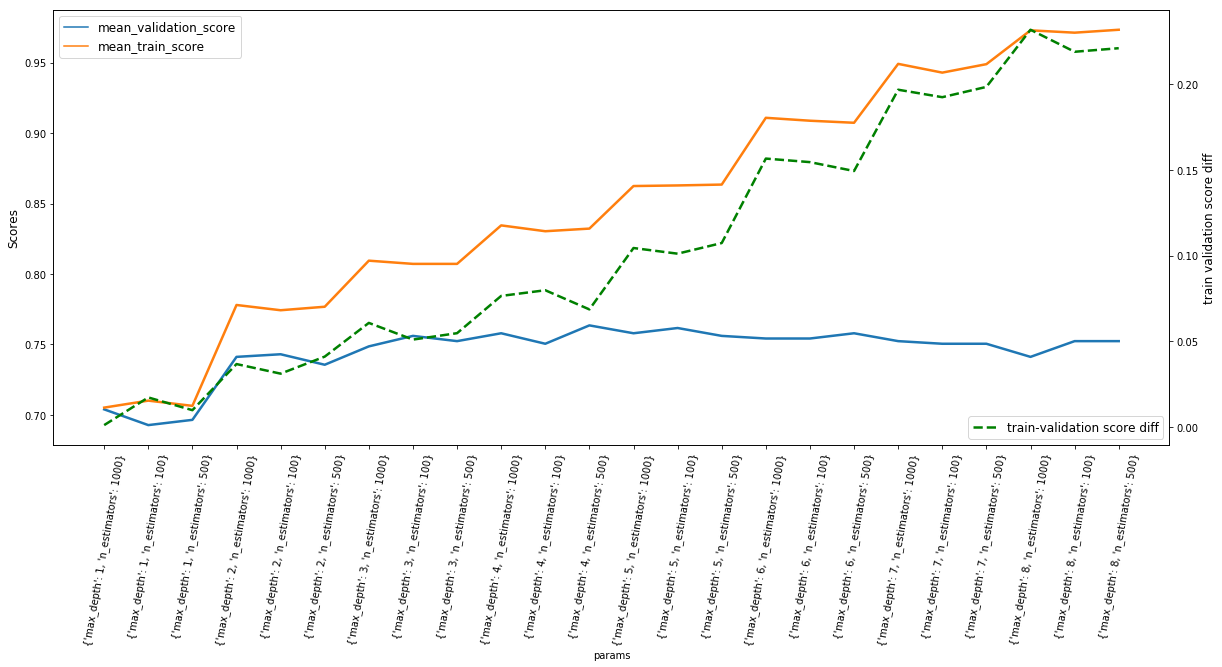

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

ax = sns.lineplot(x='params', y = 'mean_validation_score', data = cv_metrics, label = 'mean_validation_score')
ax = sns.lineplot(x='params', y = 'mean_train_score', data = cv_metrics, label = 'mean_train_score')
ax2 = ax.twinx()
ax2 = sns.lineplot(x='params', y = 'train_validation_diff', data = cv_metrics, label = 'train-validation score diff', color = 'green')
ax2.lines[0].set_linestyle("--")
ax2.lines[0].set_linewidth(2.5)
ax2.legend(loc='lower right', fontsize = 12)

ax2.set_ylabel('train-validation score diff', fontsize = 12)
fig.canvas.draw()
ax.legend(loc='upper left', fontsize = 12)
ax.set_ylabel('Scores', fontsize = 12)
ax.lines[0].set_linewidth(2.5)
ax.lines[1].set_linewidth(2.5)
xticklabels = list(ax.get_xticklabels())
ax.set_xticklabels(xticklabels, rotation=80);

#### <font color = 'blue'> Model Evaluation Metrics - Classification and Regression </font>

- Confusion Matrix
- F1 Score
- AUC – ROC
- Log Loss
- Gini Coefficient
- Concordant – Discordant Ratio
- Root Mean Squared Error
- Cross Validation (Not a metric though!)

<img src="Model Evaluation Metrics1.png" style="width: 800px;">

##### Confusion Matrix

In [137]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, ax,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[323  20]
 [ 52 142]]
Normalized confusion matrix
[[0.94169096 0.05830904]
 [0.26804124 0.73195876]]


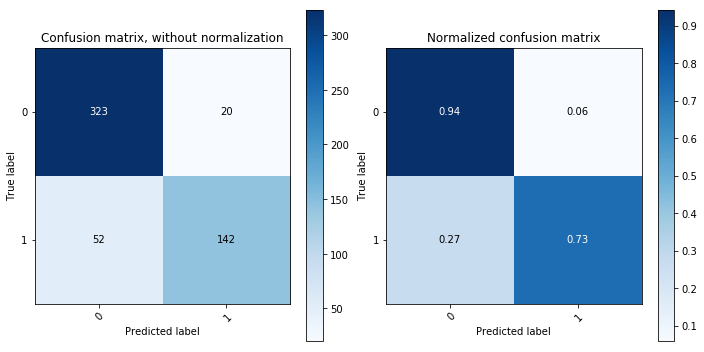

In [138]:
fig = plt.figure(figsize=(10,5))

# Confusion Matrix without Normalization
ax1 = fig.add_subplot(121)
plot_confusion_matrix(y_train, y_pred, classes=np.unique(y_train.values),  ax=ax1,
                      title='Confusion matrix, without normalization');

# Confusion Matrix with Normalization
ax2 = fig.add_subplot(122)
plot_confusion_matrix(y_train, y_pred, classes=np.unique(y_train.values),ax = ax2, 
                      normalize=True, title='Normalized confusion matrix');


##### F1 Score
For binary class problem; F1 Score for positive class ('0') is: 
- F1 = 2 * (precision * recall) / (precision + recall)
- Precision = TP/(TP+FP); First horizontal blocks in figure above - 323/(323+52)
- Recall = TP/(TP+FN); First vertical blocks in figure above - 323/(323+20) <br>

F1 Score for negative class ('1') is: 

- F1 = 2 * (precision * recall) / (precision + recall)
- Precision = TN/(TN+FN); First horizontal blocks in figure above - 142/(142+20)
- Recall = TN/(TN+FP); First vertical blocks in figure above - 142/(142+52) <br>

<br>For multi class problem average parameter should be used


##### Method 1

In [139]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('Precision Score: ' + str(precision_score(y_train, y_pred,average = None)))
print('Recall Score:    ' + str(recall_score(y_train, y_pred,average = None)))
print('F1 Score:        ' + str(f1_score(y_train, y_pred, average = None)))

Precision Score: [0.86133333 0.87654321]
Recall Score:    [0.94169096 0.73195876]
F1 Score:        [0.89972145 0.79775281]


In [144]:
recall_1 = 323/(323+20)
precision_1 = 323/(323+52)
F1_positive = 2*precision_1 *recall_1 /(precision_1+recall_1)
print(F1_positive)
recall_0 = 142/(142+52)
precision_0 = 142/(142+20)
F1_negative = 2*precision_0 *recall_0 /(precision_0+recall_0)
print(F1_negative)

0.8997214484679665
0.7977528089887641


##### Method 2

In [257]:
from sklearn import model_selection

rf_estimator = ensemble.RandomForestClassifier(max_depth = 5, n_estimators = 100)
rf = rf_estimator.fit(X_train, y_train.values.ravel())
scoring = ['f1', 'f1_micro','f1_macro']
model_selection.cross_validate(rf_estimator, X_train, y_train.values.ravel(), scoring = scoring, cv = 5, return_train_score=True)

{'fit_time': array([0.08093405, 0.07832599, 0.08175302, 0.08831096, 0.08139968]),
 'score_time': array([0.02283096, 0.02363491, 0.02646708, 0.02665305, 0.02436018]),
 'test_f1': array([0.51515152, 0.66666667, 0.73239437, 0.47058824, 0.6875    ]),
 'train_f1': array([0.78291815, 0.77818182, 0.81099656, 0.84210526, 0.82105263]),
 'test_f1_micro': array([0.7037037 , 0.75925926, 0.82407407, 0.6635514 , 0.81132075]),
 'train_f1_micro': array([0.85780886, 0.85780886, 0.87179487, 0.89534884, 0.88167053]),
 'test_f1_macro': array([0.65090909, 0.73913043, 0.80067994, 0.61200645, 0.77618243]),
 'train_f1_macro': array([0.83859946, 0.8367753 , 0.8569974 , 0.8819222 , 0.86633221])}

##### Precision Recall Curve
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Best parameters:{'max_depth': 3, 'n_estimators': 201}
Validation score:0.7597765363128491
Train score:0.8007448789571695


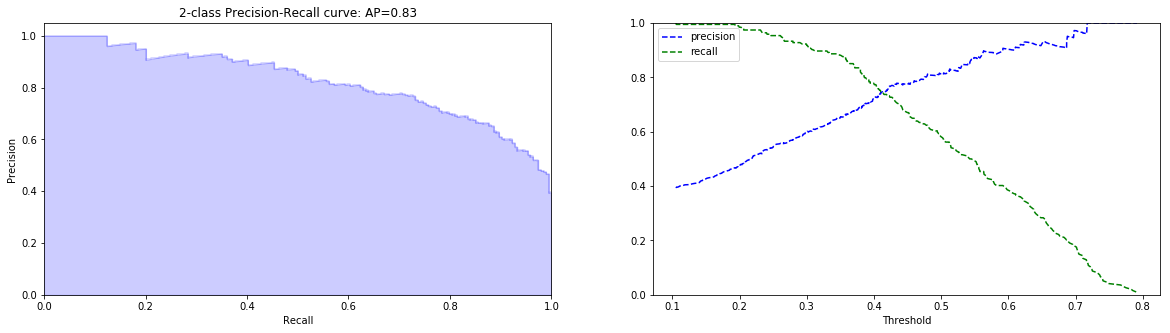

In [192]:
#Precision-recall curves are appropriate for imbalanced datasets.
#ROC curves are appropriate when the observations are balanced between each class.

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

rf_estimator = ensemble.RandomForestClassifier()
rf_grid  = {'max_depth':list(range(1,9)), 'n_estimators':list(range(1,300,100)) }
rf_final_estimator = grid_search_best_model(rf_estimator, rf_grid, X_train, y_train.values.ravel())
rf = rf_final_estimator.fit(X_train, y_train.values.ravel())

#-1 below indicates, one of the binary classes. For multi class problem, the approach is slightly different
y_score_rf = rf.predict_proba(X_train)[:,-1] 

average_precision = average_precision_score(y_train, y_score_rf)
precision, recall, threshold = precision_recall_curve(y_train, y_score_rf)

fig = plt.figure(figsize=(20,5))


ax1 = fig.add_subplot(121) 
ax1.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b')

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds, ax):
    ax.plot(thresholds, precisions[:-1], 'b--', label='precision')
    ax.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    ax.set_xlabel('Threshold')
    ax.legend(loc='upper left')
    ax.set_ylim([0,1])
ax2 = fig.add_subplot(122)
plot_prec_recall_vs_tresh(precision, recall, threshold, ax2)
plt.show()

##### ROC AUC Metric : Compute Area Under the ROC Curve (AUC) 
The ROC curve is the plot between sensitivity and (1- specificity). 
- sensitivity is also known as True Positive rate - TP/(TP+FN)
- (1- specificity) is also known as false positive rate and - FP/(FP+TN)


In [193]:
from sklearn.metrics import roc_auc_score

rf_estimator = ensemble.RandomForestClassifier()
rf_grid  = {'max_depth':list(range(1,9)), 'n_estimators':list(range(1,300,100)) }
rf_final_estimator = grid_search_best_model(rf_estimator, rf_grid, X_train, y_train.values.ravel())
rf = rf_final_estimator.fit(X_train, y_train.values.ravel())

y_pred = rf.predict(X_train)

roc_auc_score(y_train, y_pred)

Best parameters:{'max_depth': 7, 'n_estimators': 101}
Validation score:0.7635009310986964
Train score:0.9385474860335196


0.9264825223167322

In [155]:
y_score_rf = rf.predict_proba(X_train)[:,-1] 

#for svm algorithm use; there is a predict_proba alternative for svm too
y_score_rf = svm_clf.decision_function(X_trian)[:,-1] 

##### ROC Curve

##### ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

In [213]:
fpr, tpr, thresholds = roc_curve(y_train, y_score_rf)

In [216]:
thresholds

array([1.95115747, 0.95115747, 0.65804641, 0.64949611, 0.5584516 ,
       0.55592651, 0.55441766, 0.55068249, 0.53874487, 0.53802704,
       0.53044873, 0.52288412, 0.52213672, 0.52139806, 0.51687724,
       0.51523694, 0.50459293, 0.49860377, 0.49155862, 0.49154591,
       0.48287637, 0.47390804, 0.47064046, 0.47026671, 0.45940974,
       0.45738198, 0.44235657, 0.42157019, 0.41905158, 0.4121963 ,
       0.40749668, 0.38328839, 0.37705381, 0.36747334, 0.36735117,
       0.36187672, 0.36086608, 0.34008929, 0.33944984, 0.33857942,
       0.33817897, 0.33463595, 0.33245578, 0.32627626, 0.32074373,
       0.30582819, 0.30468558, 0.28966069, 0.28926132, 0.26524383,
       0.26341187, 0.00428933])

Best parameters:{'max_depth': 5, 'n_estimators': 101}
Validation score:0.7616387337057728
Train score:0.8584729981378026


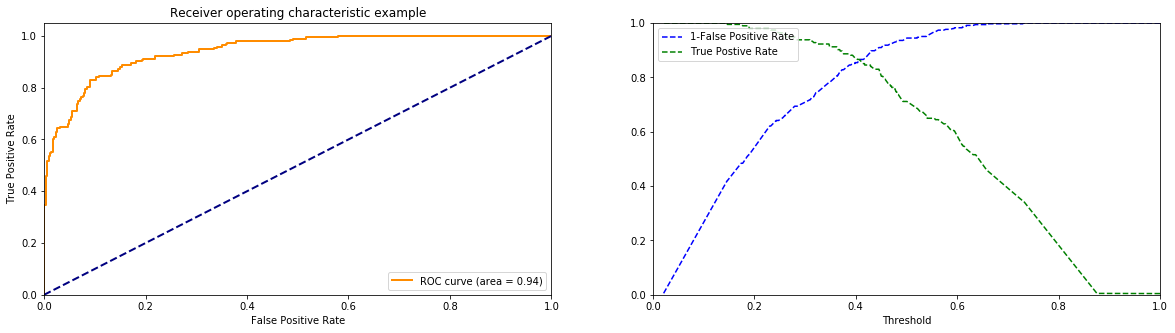

In [224]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

rf_estimator = ensemble.RandomForestClassifier()
rf_grid  = {'max_depth':list(range(1,9)), 'n_estimators':list(range(1,300,100)) }
rf_final_estimator = grid_search_best_model(rf_estimator, rf_grid, X_train, y_train.values.ravel())
rf = rf_final_estimator.fit(X_train, y_train.values.ravel())

y_score_rf = rf.predict_proba(X_train)[:,-1] 

fpr, tpr, thresholds = roc_curve(y_train, y_score_rf)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121) 
lw = 2
ax1.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver operating characteristic example')
ax1.legend(loc="lower right")

ax2 = fig.add_subplot(122) 
def plot_roc_auc_vs_tresh(fpr, tpr, thresholds, ax):
    ax.plot(thresholds, 1-fpr, 'b--', label='1-False Positive Rate')
    ax.plot(thresholds, tpr, 'g--', label = 'True Postive Rate')
    ax.set_xlabel('Threshold')
    ax.legend(loc='upper left')
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

plot_roc_auc_vs_tresh(fpr, tpr, thresholds, ax2)
plt.show()

#### Regression Metrics

In [258]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

boston = load_boston()
print(boston.data.shape) 

X = pd.DataFrame(boston.data)
X.columns = boston.feature_names
y=pd.DataFrame(boston.target)
y.columns=['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=101)

(506, 13)


In [259]:
lr_model = LinearRegression()
fitted_lr_model = model.fit(X_train, y_train)

y_pred = fitted_model.predict(X_train)

##### Mean Absolute Error

##### Method 1

In [253]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(mean_absolute_error(y_train, y_pred))
print(mean_squared_error(y_train, y_pred))

3.073138872504538
19.475903780713956


##### Method 2

In [251]:
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error']

model_selection.cross_validate(fitted_lr_model, X_train, y_train.values.ravel(), scoring = scoring, cv = 5, return_train_score=True)

## neg_mean_absolute_error: negative loss function - higher value better the score
## mean_absolute_error: loss function - lower the loss better the score

{'fit_time': array([0.00185823, 0.00250387, 0.00187612, 0.0014081 , 0.00191283]),
 'score_time': array([0.00218391, 0.00131202, 0.00180197, 0.00128889, 0.00148797]),
 'test_neg_mean_absolute_error': array([-3.84100634, -2.58715472, -3.43469196, -3.0764388 , -3.16405705]),
 'train_neg_mean_absolute_error': array([-2.82254991, -3.19976153, -3.09979384, -3.10841587, -3.09642987]),
 'test_neg_mean_squared_error': array([-31.71803297, -18.41722129, -21.71004466, -17.89478079,
        -20.66659922]),
 'train_neg_mean_squared_error': array([-17.00879276, -20.05022056, -19.40048258, -20.2734359 ,
        -19.26720719])}

In [244]:
#### R2

##### Method 1

In [247]:
from sklearn.metrics import r2_score

r2_score(y_train, y_pred)

0.7471263931918002

##### Method 2

In [249]:
model_selection.cross_validate(fitted_lr_model, X_train, y_train.values.ravel(), scoring = 'r2', cv = 5, return_train_score=True)

{'fit_time': array([0.00188112, 0.0022831 , 0.00193787, 0.00188327, 0.00142407]),
 'score_time': array([0.00124216, 0.0011251 , 0.00090528, 0.00100088, 0.00099993]),
 'test_score': array([0.6573993 , 0.70766619, 0.74206462, 0.78501158, 0.61972667]),
 'train_score': array([0.76286304, 0.74920388, 0.74208052, 0.73129592, 0.76579393])}